In [258]:
%reset -f

In [282]:
from IPython.display import display, HTML
from sklearn import metrics
from sklearn import cross_validation
from scipy import interp
import pandas as pd
import numpy as np
import os

import sys
sys.path.insert(1, "/home/aegle/projects/myosa/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score
from TypeFeatFS import DiscreteFS, ContinuousFS
from TypeFeatFilter import DiscreteFilter, ContinuousFilter
from OutlierFiltering import OutlierFiltering
from typeFeat_score import typeFeat_score

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

In [298]:
folder = "equal_more_four" #"more_than_four"

In [302]:
dfAll =[]
datasets = [0,1,2]
for ds in datasets:
    pathDir = os.path.join('resources','results',folder,'ds_' + str(ds)) 
    path, dirs, files = os.walk(pathDir).next()
    file_count = len(files)

    for num_exp in range(file_count):
        ddf = pd.read_pickle(os.path.join('resources','results',folder,'ds_' + str(ds),'results_pipe_' 
                                         + str(ds) + '_' + str(num_exp) + '.pkl'))
    ddf["ds"] = ds
    print ddf.shape
    dfAll.append(ddf)

(76, 23)
(76, 23)
(76, 23)


In [303]:
dfs = pd.DataFrame(np.vstack(dfAll), columns=ddf.columns)

dfs.cv_f1_mean = pd.to_numeric(dfs.cv_f1_mean)
dfs.cv_rec_mean = pd.to_numeric(dfs.cv_rec_mean)
dfs.cv_prec_mean = pd.to_numeric(dfs.cv_prec_mean)

dfs.cv_f1_std = pd.to_numeric(dfs.cv_f1_std)
dfs.cv_prec_std = pd.to_numeric(dfs.cv_prec_std)
dfs.cv_rec_std = pd.to_numeric(dfs.cv_rec_std)
dfs.exp = pd.to_numeric(dfs.exp)

dfs["cv_f1"] = dfs["cv_f1_mean"].round(2).astype(str).str.cat(dfs["cv_f1_std"].round(2).astype(str), sep="+/-")
dfs["cv_prec"] = dfs["cv_prec_mean"].round(2).astype(str).str.cat(dfs["cv_prec_std"].round(2).astype(str), sep="+/-")
dfs["cv_rec"] = dfs["cv_rec_mean"].round(2).astype(str).str.cat(dfs["cv_rec_std"].round(2).astype(str), sep="+/-")
dfs["num_nones"] = np.sum(np.hstack(((dfs.sm == "none").reshape(-1,1),(dfs.fs == "none").reshape(-1,1))), axis=1)

print dfs.columns.tolist()
print dfs.shape

['exp', 'out', 'fs', 'sm', 'cls', 'metric', 'params', 'tr_f1', 'tr_prec', 'tr_rec', 'cv_f1_mean', 'cv_f1_std', 'cv_prec_mean', 'cv_prec_std', 'cv_rec_mean', 'cv_rec_std', 'test_f1', 'test_prec', 'test_rec', 'test_auc', 'time', 'pipeline', 'ds', 'cv_f1', 'cv_prec', 'cv_rec', 'num_nones']
(228, 27)
         cv_f1      cv_prec       cv_rec
0  0.52+/-0.19  0.54+/-0.22  0.54+/-0.18
1  0.55+/-0.14   0.58+/-0.2  0.59+/-0.12
2  0.47+/-0.17   0.48+/-0.2   0.5+/-0.16
3  0.47+/-0.17   0.48+/-0.2   0.5+/-0.16
4   0.5+/-0.19  0.52+/-0.19  0.51+/-0.19


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


### 1. All timepoints and all pipelines

#### a) Show performances of best pipelines

In [346]:
idx = []
for ds in datasets:
    dfTmp = dfs[dfs.ds == ds].sort_values(["cv_f1_mean","exp"], ascending=False)
    idx.extend(dfTmp.iloc[:1].index.tolist())

print idx    
dfs.ix[idx][["exp","ds","sm","fs","metric","cls","params","cv_f1_mean","cv_f1_std","test_f1"]]

[50, 126, 206]


,exp,ds,sm,fs,metric,cls,params,cv_f1_mean,cv_f1_std,test_f1
50,50,0,none,none,f1_weighted,svmRBF,"[0.001, None, 50]",0.71,0.18,0.76
126,50,1,none,none,f1_weighted,svmRBF,"[0.001, None, 30]",0.83,0.08,0.84
206,54,2,after,none,f1_weighted,logReg,"[None, 0.5, 3, l1]",0.90,0.12,0.85


[50] [50] [0]
[126] [50] [1]
[206] [54] [2]


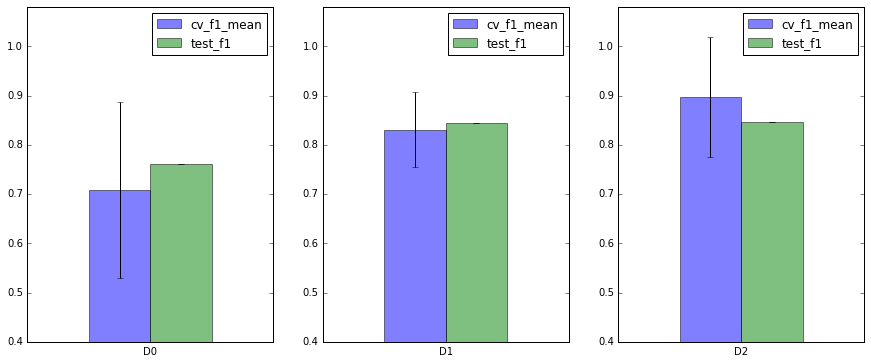

In [325]:
#Plot performances best classifier algorithms
plt.figure(figsize=(15,6))
w = 0.20
thr = 1

errs = dfs.ix[idx]["cv_f1_std"].values
errs = np.vstack((errs, np.array([0,0,0]))).T

for i,ds in enumerate(datasets):
    ax = plt.subplot(1,3,ds+1)
    dfTmp = dfs[dfs.ds == ds].sort_values("cv_f1_mean", ascending=False)
    dfTmp.iloc[:thr][["cv_f1_mean","test_f1"]].plot(kind="bar", yerr=[[errs[i,0]],[0.0]], rot=0, ax=ax, alpha=0.5)
    print dfTmp.iloc[:thr].index.values, dfTmp.iloc[:thr]["exp"].values, dfTmp.iloc[:thr]["ds"].values
    ax.set_xticks([])
    ax.set_xlabel("D"+str(ds))
    ax.set_ylim(0.4,1.08)
    
plt.legend()
plt.show()


#### b) Compute for each timepoint performances of best pipelines grouped by algorithm type

In [347]:
tmp = []
for d in dfs.ds.unique():
    for c in dfs.cls.unique():
        tmp.append(dfs[np.logical_and(dfs.ds == d,dfs.cls == c)]
                   [["exp","ds","sm","fs","metric","cls","params","cv_f1_mean","cv_f1_std","cv_f1","test_f1", "pipeline"]].
                   sort_values(["cv_f1_mean","exp"], ascending=False).iloc[0].values)        

dfTmp = pd.DataFrame(tmp, columns=["exp","ds","sm","fs","metric","cls","params","cv_f1_mean","cv_f1_std","cv_f1","test_f1", "pipeline"])
dfTmp.sort_values(["ds","cv_f1_mean"], ascending=True)[["exp","ds","sm","fs","metric","cls","params","cv_f1","test_f1"]]

,exp,ds,sm,fs,metric,cls,params,cv_f1,test_f1
1,59,0,after,none,f1_weighted,rf,"[gini, None, None, 150, 5]",0.61+/-0.18,0.84
0,69,0,none,rfe_rf_fs,f1_weighted,knn,"[21, uniform, 5, 0.1]",0.66+/-0.2,0.60
3,45,0,none,none,precision_weighted,logReg,"[None, 30, l2]",0.7+/-0.16,0.76
2,50,0,none,none,f1_weighted,svmRBF,"[0.001, None, 50]",0.71+/-0.18,0.76
4,48,0,none,none,f1_weighted,nn,"[(30, 30), 0.01]",0.71+/-0.18,0.76
5,6,1,none,combine_fs,f1_weighted,knn,"[uniform, 1, 20]",0.62+/-0.22,0.46
6,1,1,none,combine_fs,precision_weighted,rf,"[100, gini, 4, balanced, 20]",0.7+/-0.1,0.54
8,55,1,after,none,precision_weighted,logReg,"[None, 0.5, 3, l2]",0.76+/-0.15,0.84
9,58,1,after,none,f1_weighted,nn,"[(100, 100), 4, 0.01]",0.8+/-0.11,0.84
7,50,1,none,none,f1_weighted,svmRBF,"[0.001, None, 30]",0.83+/-0.08,0.84


#### Compute significance test among best classifiers (grouped by type)

In [355]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import psturng
import scipy.stats as stats

all_cvs = []
for ds in dfTmp.ds.unique():
    
    print "\nDS:", ds
    datafilenames = []
    datafilenames.append(os.path.join('resources','data_partition_cl0_short_no_monit_14012016.pkl'))
    datafilenames.append(os.path.join('resources','data_partition_cl0_short_1m_monit_14012016.pkl'))
    datafilenames.append(os.path.join('resources','data_partition_cl0_short_3m_1m_monit_14012016.pkl'))


    #Load Train & test data
    f = file(datafilenames[ds],"rb")
    X_train = np.load(f).astype(float)
    y_train = np.load(f).astype(int)
    X_test = np.load(f).astype(float)
    y_test = np.load(f).astype(int)
    cols = np.load(f)
    tr_codes = np.load(f)
    ts_codes = np.load(f)
    feat_types = np.load(f)
    feat_types = dict(feat_types.tolist())
    f.close()

    #Join data
    X_all = np.vstack((X_train,X_test))
    y_all = np.hstack((y_train, y_test)).reshape(-1,1)
    all_codes = np.hstack((tr_codes,ts_codes))

    #CV data
    cv_outer = cross_validation.StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.30, random_state=42) 
    
    #Compute all k-fold cv
    cvs = []
    for exp in dfTmp[dfTmp.ds == ds].exp.values:
        dt = dfTmp[np.logical_and(dfTmp.ds == ds, dfTmp.exp == exp)]
        cls = dt["pipeline"].values[0]
                
        cv = cross_validation.cross_val_score(cls, X_train, y_train, cv=cv_outer, scoring='f1_weighted', n_jobs=-1)   
        for c in cv:
            cvs.append([ds, exp, c])
    
    
    #Compute significance (anova)
    cvs = np.array(cvs)        
    all_cvs.append(cvs)
    st, p = stats.f_oneway(*[cvs[cvs[:,1] == i,1] for i in np.unique(cvs[:,1])])
    
    print "Pipelines:", dfTmp[dfTmp.ds == ds].exp.values
    print "stat:",st, "p-value:", p
    print "Means:",[np.mean(cvs[cvs[:,1] == i,1]) for i in np.unique(cvs[:,1])]
    print "std:",[np.std(cvs[cvs[:,1] == i,1]) for i in np.unique(cvs[:,1])]

    #Posthoc pair-wise significance tests        
    # http://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/
    # https://stackoverflow.com/questions/16049552/what-statistics-module-for-python-supports-one-way-anova-with-post-hoc-tests-tu
    # http://jpktd.blogspot.com.es/2013/03/multiple-comparison-and-tukey-hsd-or_25.html    
    mc = MultiComparison(cvs[:,2], cvs[:,1])
    
    #Tukey test
    #result = mc.tukeyhsd()
    #print
    #print(result)
    #print(mc.groupsunique)        

    #T-test with bonferroni correction:
    print
    print mc.allpairtest(stats.ttest_rel, method='b')[0]    


DS: 0
Pipelines: [69 59 50 45 48]
stat: -4.73504682502e+16 p-value: nan
Means: [45.0, 48.0, 50.0, 59.0, 69.0]
std: [0.0, 0.0, 0.0, 0.0, 0.0]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=b
alphacSidak=0.01, alphacBonf=0.005
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 45.0   48.0   0.4535 0.6609    1.0    False 
 45.0   50.0   0.4535 0.6609    1.0    False 
 45.0   59.0   1.9171 0.0875   0.8746  False 
 45.0   69.0   1.4525 0.1803    1.0    False 
 48.0   50.0    nan    nan      nan    False 
 48.0   59.0   1.8263 0.1011    1.0    False 
 48.0   69.0   1.0345 0.3279    1.0    False 
 50.0   59.0   1.8263 0.1011    1.0    False 
 50.0   69.0   1.0345 0.3279    1.0    False 
 59.0   69.0  -0.7602 0.4666    1.0    False 
---------------------------------------------

DS: 1


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipelines: [ 6  1 50 55 58]
stat: inf p-value: 0.0
Means: [1.0, 6.0, 50.0, 55.0, 58.0]
std: [0.0, 0.0, 0.0, 0.0, 0.0]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=b
alphacSidak=0.01, alphacBonf=0.005
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 1.0    6.0    0.6406 0.5378    1.0    False 
 1.0    50.0  -3.5115 0.0066   0.066   False 
 1.0    55.0  -1.3913 0.1976    1.0    False 
 1.0    58.0  -2.9769 0.0155   0.1553  False 
 6.0    50.0  -2.5225 0.0326   0.3263  False 
 6.0    55.0  -1.7542 0.1133    1.0    False 
 6.0    58.0  -2.3683 0.042    0.4203  False 
 50.0   55.0   2.1989 0.0554   0.5544  False 
 50.0   58.0   0.8964 0.3934    1.0    False 
 55.0   58.0  -1.8321 0.1002    1.0    False 
---------------------------------------------

DS: 2
Pipelines: [16 39 53 54 58]
stat: inf p-value: 0.0
Means: [16.0, 39.0, 53.0, 54.0, 58.0]
std: [0.0, 0.0, 0.0, 0.0, 0.0]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=b
alphacSida

#### Plot best classifiers by dataset

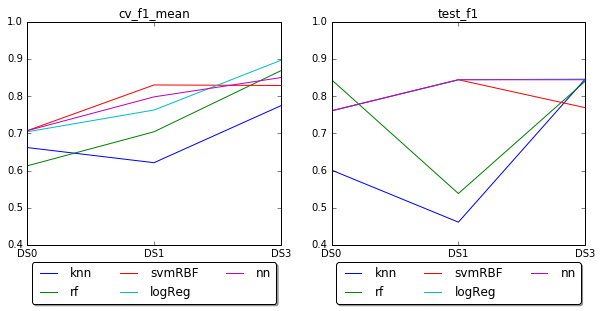

In [356]:
plt.figure(figsize=(10,4))
for i,colPerf in enumerate(["cv_f1_mean","test_f1"]):
    ax = plt.subplot(1,2,i+1)
    for c in dfTmp.cls.unique():
        dfTmp[dfTmp.cls==c].plot(x="ds",y=colPerf, ax=ax,label=c)    
    plt.xticks(dfs.ds.unique(), dfs.ds.unique())
    plt.ylim(0.4,1.0)
    plt.xticks(datasets,["DS0","DS1","DS3"])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
    plt.xlabel("")
    ax.set_title(colPerf)

cls,knn,logReg,rf,nn,svmRBF
0,0.66,0.70,0.61,0.71,0.71
1,0.62,0.76,0.70,0.80,0.83
2,0.77,0.90,0.87,0.85,0.83


cls,knn,logReg,rf,nn,svmRBF
0,0.20,0.16,0.18,0.18,0.18
1,0.22,0.15,0.10,0.11,0.08
2,0.09,0.12,0.12,0.08,0.11


3 3


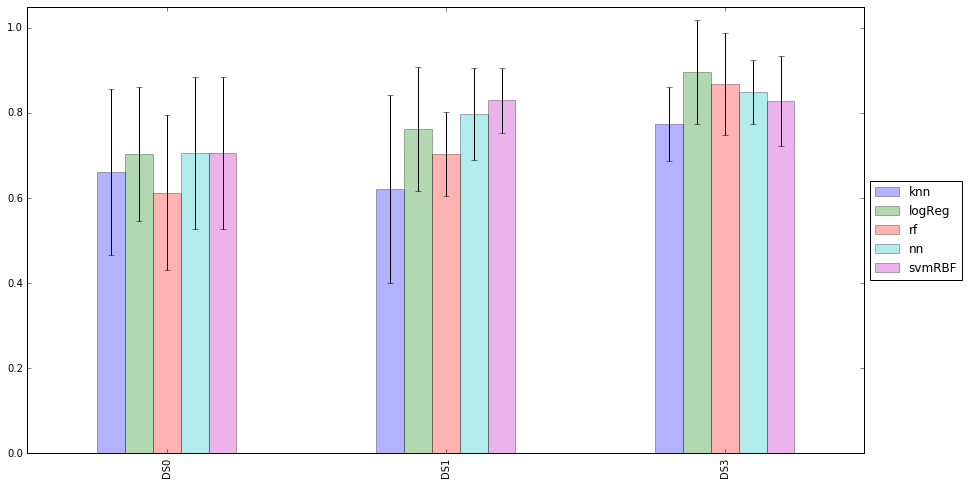

In [357]:
dfPivot = dfTmp.pivot_table(values="cv_f1_mean",index="ds",columns="cls").reset_index()[["knn","logReg","rf","nn","svmRBF"]]
display(dfPivot)
dfErr = dfTmp.pivot_table(values="cv_f1_std",index="ds",columns="cls").reset_index()[["knn","logReg","rf","nn","svmRBF"]]
display(dfErr)

print len(dfPivot), len(dfErr)
plt.figure(figsize=(15,8))
dfPivot.plot(kind="bar", y=dfPivot.columns, yerr=dfErr,figsize=(15,8), alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(datasets,["DS0","DS1","DS3"])
plt.ylim(0.0,1.05)
plt.show()

#### Statistical difference among best pipelines in cv classifiers for different datasets

In [370]:
best_exp = dfs.ix[idx]["exp"].values
print idx
print best_exp

cvs_best = []
for i,c in enumerate(all_cvs):
    #print best_exp[i]
    #print c[c[:,0] == best_exp[i],:]
    #print np.mean(c[c[:,0] == best_exp[i],1])
    cvs_best.extend(c[np.logical_and(c[:,0] == i, c[:,1] == best_exp[i]),:].tolist())    

cvs_best = np.array(cvs_best)
print cvs_best.shape
st, p = stats.f_oneway(*[cvs_best[cvs_best[:,0] == i, 2] for i in np.unique(cvs_best[:,0])])

print "stat:",st, "p-value:", p
print "Means:",[np.mean(cvs_best[cvs_best[:,0] == i,2]) for i in np.unique(cvs_best[:,0])]
print "std:",[np.std(cvs_best[cvs_best[:,0] == i,2]) for c in np.unique(cvs_best[:,0])]

#Posthoc pair-wise significance tests        
mc = MultiComparison(cvs_best[:,2], np.core.defchararray.add(cvs_best[:,0].astype(str),cvs_best[:,1].astype(str)),)

#T-test with bonferroni correction:
print
print mc.allpairtest(stats.ttest_rel)[0] 

[50, 126, 206]
[50 50 54]
(30, 3)
stat: 3.70758492885 p-value: 0.0377821729389
Means: [0.70740259740259737, 0.82849687349687362, 0.86264790764790766]
std: [0.10265896056356723, 0.10265896056356723, 0.10265896056356723]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonf
alphacSidak=0.02, alphacBonf=0.017
 group1  group2   stat   pval  pval_corr reject
-----------------------------------------------
0.050.0 1.050.0 -2.4255 0.0383   0.1148  False 
0.050.0 2.054.0 -3.0156 0.0146   0.0437   True 
1.050.0 2.054.0 -0.7331 0.4821    1.0    False 
-----------------------------------------------


## 2. Pipelines by timepoint

In [386]:
ds = 1

In [387]:
df = dfs[dfs.ds == ds].sort_values("cv_f1_mean", ascending=False)
df.cv_f1_mean = pd.to_numeric(df.cv_f1_mean)
df.cv_rec_mean = pd.to_numeric(df.cv_rec_mean)
df.cv_prec_mean = pd.to_numeric(df.cv_prec_mean)

### 2.1 All pipelines

In [388]:
print "\nDS:", ds
datafilenames = []
datafilenames.append(os.path.join('resources','data_partition_cl0_short_no_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_partition_cl0_short_1m_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_partition_cl0_short_3m_1m_monit_14012016.pkl'))


#Load Train & test data
f = file(datafilenames[ds],"rb")
X_train = np.load(f).astype(float)
y_train = np.load(f).astype(int)
X_test = np.load(f).astype(float)
y_test = np.load(f).astype(int)
cols = np.load(f)
tr_codes = np.load(f)
ts_codes = np.load(f)
feat_types = np.load(f)
feat_types = dict(feat_types.tolist())
f.close()

#Join data
X_all = np.vstack((X_train,X_test))
y_all = np.hstack((y_train, y_test)).reshape(-1,1)
all_codes = np.hstack((tr_codes,ts_codes))

#CV data
cv_outer = cross_validation.StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.30, random_state=42) 


DS: 1


#### a) Avg all pipelines by classifier algorithm

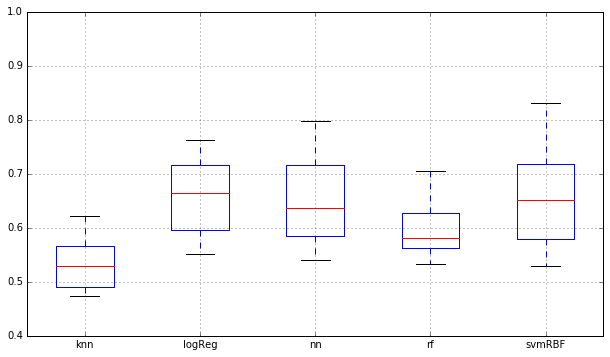

In [389]:
df.boxplot(by="cls",column=["cv_f1_mean"],figsize=(10,6))
plt.ylim(0.4,1.0)
plt.suptitle("")
plt.xlabel("")
plt.title("")

#### ROC curves

In [390]:
idx = df.groupby(['cls'])['cv_f1_mean'].transform(max) == df['cv_f1_mean']
print idx[idx==True].index.tolist()

dfDescIdx = df[idx]
dfDescIdx = dfDescIdx.groupby("cls").first()
print dfDescIdx.exp.values

dfDescIdx[["fs","sm","metric","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']]

[126, 119, 117, 134, 121, 131, 120, 77, 82]
[ 6 45 41  1 50]


,fs,sm,metric,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
cls,,,,,,,,,,,
knn,combine_fs,none,f1_weighted,"[uniform, 1, 20]",1.00,0.62+/-0.22,0.63+/-0.25,0.64+/-0.2,0.46,0.46,0.47
logReg,none,none,precision_weighted,"[None, 30, l2]",1.00,0.76+/-0.11,0.8+/-0.11,0.77+/-0.1,0.84,0.85,0.88
nn,none,after,precision_weighted,"[(100, 100), 4, 0.01]",1.00,0.8+/-0.11,0.82+/-0.11,0.8+/-0.11,0.84,0.85,0.88
rf,combine_fs,none,precision_weighted,"[100, gini, 4, balanced, 20]",1.00,0.7+/-0.1,0.76+/-0.1,0.72+/-0.09,0.54,0.54,0.54
svmRBF,none,none,f1_weighted,"[0.001, None, 30]",1.00,0.83+/-0.08,0.85+/-0.07,0.83+/-0.07,0.84,0.85,0.88


CV roc curves

array([ 0.        ,  0.54166667,  0.66333333,  0.725     ,  0.78666667,
        0.84833333,  0.91      ,  0.955     ,  1.        ])

array([ 0.        ,  0.50958333,  0.70916667,  0.76208333,  0.815     ,
        0.86541667,  0.91583333,  0.95791667,  1.        ])

array([ 0.        ,  0.51388889,  0.74111111,  0.78833333,  0.83555556,
        0.87944444,  0.92333333,  0.96166667,  1.        ])

array([ 0.        ,  0.47041667,  0.72583333,  0.79041667,  0.855     ,
        0.89333333,  0.93166667,  0.96583333,  1.        ])

array([ 0.        ,  0.47983333,  0.73966667,  0.80483333,  0.87      ,
        0.90416667,  0.93833333,  0.96916667,  1.        ])

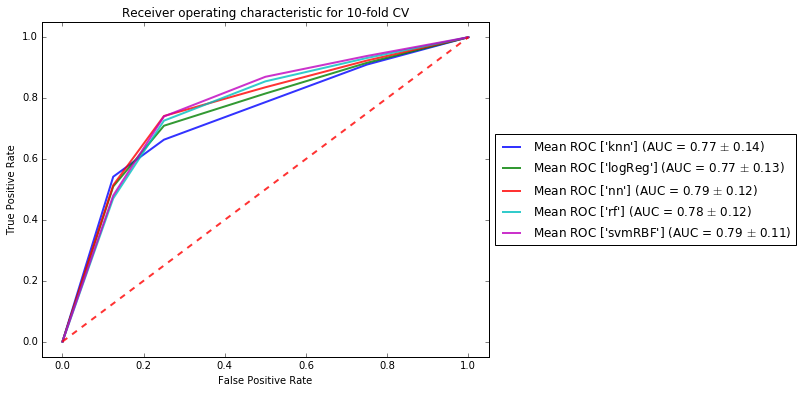

In [391]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 9)

i = 0

plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
for exp in dfDescIdx.exp.values:
    
    cls_name = dfDescIdx[dfDescIdx.exp == exp].index.values
    cls = dfDescIdx[dfDescIdx.exp == exp].pipeline.iloc[0]

    for train, test in cv_outer:

        y_pred = cls.fit(X_train[train],y_train[train]).predict(X_train[test])

        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train[test], y_pred)

        tprs.append(interp(mean_fpr, fpr, tpr))  
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)    

        aucs.append(roc_auc)
        i += 1

    #Plot auc mean line and shadow mean area
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    display(mean_tpr)

    ax.plot(mean_fpr, mean_tpr,
             label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (cls_name,mean_auc, std_auc),
             lw=2, alpha=.8)
    
#Plot guess line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 10-fold CV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

Test roc curves


DS: 1
6
Pipeline(steps=[('Imputer', TypeFeatImputer(allNameCols=array(['GENDER', 'ACTIVE', 'RETIRED', 'AGE', 'SMOKER', 'SMOKE_PACK_YEAR',
       'SMOKE_EX_YEAR', 'ALCOHOL', 'ALCOHOL_GR_DAY', 'CAFES_DAY',
       'DEPRESSION', 'ANXIETY', 'HTA', 'CARDIOPATHY', 'RESP_DIS',
       'DIABETES', 'OBESITY', 'DISLIPEMIA', 'OB...owski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
[0 1 1 1 0 0 0 0 1 0 1 1 1]
[1 1 0 1 1 0 0 1 1 0 1 0 1]
[ 1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
0.607142857143
0.607142857143
[ 0.   0.5  1. ]
[ 0.          0.71428571  1.        ]

DS: 1
45
Pipeline(steps=[('Imputer', TypeFeatImputer(allNameCols=array(['GENDER', 'ACTIVE', 'RETIRED', 'AGE', 'SMOKER', 'SMOKE_PACK_YEAR',
       'SMOKE_EX_YEAR', 'ALCOHOL', 'ALCOHOL_GR_DAY', 'CAFES_DAY',
       'DEPRESSION', 'ANXIETY', 'HTA', 'CARDIOPATHY', 'RESP_DIS',
       'DIABETES', 'OBESITY', 'DISLIPEMIA', 'OB...alty='l2', random_state=42, solver='liblinear', tol=0.0001,


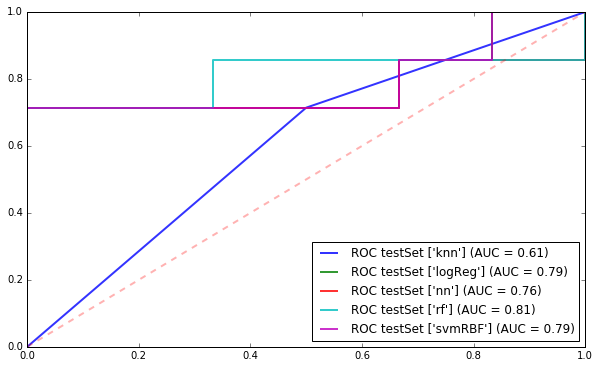

In [392]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
for exp in dfDescIdx.exp.values:
    
    cls_name = dfDescIdx[dfDescIdx.exp == exp].index.values
    cls = dfDescIdx[dfDescIdx.exp == exp].pipeline.iloc[0]

    y_pred = cls.predict(X_test)
    y_prob = cls.predict_proba(X_test)
    
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_prob[:,1])
    roc_auc = metrics.auc(fpr_test, tpr_test)

    #fpr_test_sc, tpr_test_sc, _ = metrics.roc_curve(y_test, y_score)
    #roc_auc_sc = metrics.auc(fpr_test, tpr_test)

    test_auc_w = metrics.roc_auc_score(y_test, y_pred, average='weighted')

    print
    print "DS:", ds
    print exp
    print cls    
    print y_test
    print y_pred
    print y_prob[:,1]    
    print roc_auc
    print test_auc_w
    print fpr_test
    print tpr_test

    ax.plot(fpr_test, tpr_test, label='ROC testSet %s (AUC = %0.2f)' % (cls_name, roc_auc),lw=2, alpha=.8)
    ax.legend(loc='lower right')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='', alpha=.3)    
plt.show()

#### Statistical significance test among all classifiers for the dataset

In [393]:
#Compute all k-fold cv
cvs = []
for exp in df.exp.values:
    dt = df[df.exp == exp]
    cls = dt["pipeline"].values[0]

    cv = cross_validation.cross_val_score(cls, X_train, y_train, cv=cv_outer, scoring='f1_weighted', n_jobs=-1)   
    for c in cv:
        cvs.append([exp, c])

#Compute significance (anova)
cvs = np.array(cvs)

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

In [394]:
#Multiple tests
st, p = stats.f_oneway(*[cvs[cvs[:,0] == i,1] for i in np.unique(cvs[:,0])])
print "stat:",st, "p-value:", p


#Find pairwise adhoc significance of dependent tests
mc = MultiComparison(cvs[:,1], cvs[:,0])

#Tukey test
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

#T-test with bonferroni correction:
print
print mc.allpairtest(stats.ttest_rel,method='b')[0] 

stat: 2.07665146572 p-value: 1.16055190762e-06
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.0    1.0    0.0808  -0.2854 0.447  False 
 0.0    2.0    -0.049  -0.4152 0.3172 False 
 0.0    3.0   -0.0193  -0.3855 0.3469 False 
 0.0    4.0    0.0722   -0.294 0.4384 False 
 0.0    5.0    0.0722   -0.294 0.4384 False 
 0.0    6.0    0.0205  -0.3457 0.3867 False 
 0.0    7.0   -0.0795  -0.4458 0.2867 False 
 0.0    8.0   -0.0588   -0.425 0.3074 False 
 0.0    9.0    0.0686  -0.2976 0.4348 False 
 0.0    10.0  -0.0548   -0.421 0.3114 False 
 0.0    11.0  -0.0548   -0.421 0.3114 False 
 0.0    12.0    0.05   -0.3162 0.4162 False 
 0.0    13.0   0.0291  -0.3371 0.3953 False 
 0.0    14.0   0.0093  -0.3569 0.3755 False 
 0.0    15.0   0.0332   -0.333 0.3995 False 
 0.0    16.0    0.0    -0.3662 0.3662 False 
 0.0    17.0   -0.057  -0.4232 0.3092 False 
 0.0    18.0  -0.0583  -0.4245 0.3079 False 
 0

#### b) Plot performances (top-10 classifiers)

In [335]:
thr = 10

In [336]:
dfDesc = df.sort_values("cv_f1_mean", ascending=False)
   
dfDesc[["fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          'test_prec', 'test_rec',"test_f1"]].iloc[:thr,:]

,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_prec,test_rec,test_f1
50,none,none,f1_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.77,0.85,0.76
48,none,none,f1_weighted,nn,"[(30, 30), 0.01]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.77,0.85,0.76
43,none,none,precision_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.77,0.85,0.76
44,none,none,f1_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.77,0.85,0.76
45,none,none,precision_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.77,0.85,0.76
53,none,after,precision_weighted,svmRBF,"[0.001, None, 3, 50]",1.00,0.7+/-0.16,0.75+/-0.19,0.71+/-0.15,0.77,0.85,0.76
52,none,after,f1_weighted,svmRBF,"[0.001, None, 3, 50]",1.00,0.7+/-0.16,0.75+/-0.19,0.71+/-0.15,0.77,0.85,0.76
58,none,after,f1_weighted,nn,"[(50, 50), 4, 0.01]",1.00,0.7+/-0.14,0.77+/-0.15,0.71+/-0.13,0.77,0.85,0.76
49,none,none,precision_weighted,nn,"[(150,), 0.01]",1.00,0.69+/-0.18,0.76+/-0.2,0.71+/-0.17,0.77,0.85,0.76
12,combine_fs,after,f1_weighted,svmRBF,"[0.001, None, 3, 40, 15]",0.93,0.68+/-0.19,0.7+/-0.2,0.69+/-0.18,0.62,0.79,0.57


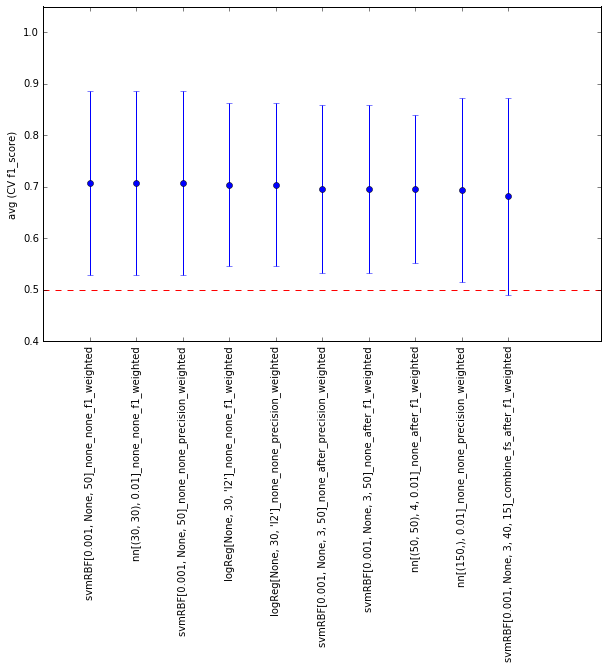

In [337]:
plt.figure(figsize=(10,6))
plt.errorbar(x = range(thr), y= df["cv_f1_mean"].iloc[:thr], yerr=df["cv_f1_std"].iloc[:thr], linestyle='None', marker='o')
plt.xticks(range(thr),df["cls"].iloc[:thr].str.cat(df["params"].iloc[:thr].astype(str), sep="").
           str.cat(df["fs"].iloc[:thr],sep="_").
           str.cat(df["sm"].iloc[:thr],sep="_").
           str.cat(df["metric"].iloc[:thr],sep="_"),
           rotation=90)
plt.ylabel("avg (CV f1_score)")
plt.ylim(0.4,1.05)
plt.xlim(-1,11)
plt.axhline(0.5,c="r",linestyle="--", label="random")
plt.show()

#### c) Group performances by (algorithms, fs, sampling, metric)

In [371]:
thr=df.shape[0] #10

In [372]:
dfOrd = df.sort_values("cv_f1_mean", ascending=False)

#Classifier algorithms
dfCls = dfOrd.iloc[:thr,:].groupby(["cls"]).count().reset_index()
dfCls["cont"] = dfCls.iloc[:,-1]
dfCls = dfCls[["cls","cont"]]

dfClsPerf = dfOrd.iloc[:thr,:][["cls","cv_f1_mean"]].groupby(["cls"]).agg(["mean","max","min","std"]).reset_index()
dfClsPerf["cv_mean"] = dfClsPerf.iloc[:,1]
dfClsPerf["cv_max"] = dfClsPerf.iloc[:,2]
dfClsPerf["cv_min"] = dfClsPerf.iloc[:,3]
dfClsPerf["cv_std"] = dfClsPerf.iloc[:,4]
dfClsPerf = dfClsPerf[["cls","cv_mean","cv_max","cv_min","cv_std"]]

dfClsMerged = pd.merge(dfCls,dfClsPerf,on="cls")
dfClsMerged["cv_mean"] = dfClsMerged.iloc[:,2]
dfClsMerged["cv_max"] = dfClsMerged.iloc[:,3]
dfClsMerged["cv_min"] = dfClsMerged.iloc[:,4]
dfClsMerged["cv_std"] = dfClsMerged.iloc[:,5]
dfClsMerged = dfClsMerged[["cls","cont","cv_mean","cv_max","cv_min","cv_std"]].sort_values(["cont","cv_mean"], ascending=False)
display(dfClsMerged)

#Feature selection
dfFs = dfOrd.iloc[:thr,:].groupby(["fs"]).count().reset_index()
dfFs["cont"] = dfFs.iloc[:,-1]
dfFs = dfFs[["fs","cont"]]

dfFsPerf = dfOrd.iloc[:thr,:][["fs","cv_f1_mean"]].groupby(["fs"]).agg(["mean","max","min","std"]).reset_index()
dfFsPerf["cv_mean"] = dfFsPerf.iloc[:,1]
dfFsPerf["cv_max"] = dfFsPerf.iloc[:,2]
dfFsPerf["cv_min"] = dfFsPerf.iloc[:,3]
dfFsPerf["cv_std"] = dfFsPerf.iloc[:,4]
dfFsPerf = dfFsPerf[["fs","cv_mean","cv_max","cv_min","cv_std"]]

dfFsMerged = pd.merge(dfFs,dfFsPerf,on="fs")
dfFsMerged["cv_mean"] = dfFsMerged.iloc[:,2]
dfFsMerged["cv_max"] = dfFsMerged.iloc[:,3]
dfFsMerged["cv_min"] = dfFsMerged.iloc[:,4]
dfFsMerged["cv_std"] = dfFsMerged.iloc[:,5]

dfFsMerged = dfFsMerged[["fs","cont","cv_mean","cv_max","cv_min","cv_std"]].sort_values(["cont","cv_mean"], ascending=False)
display(dfFsMerged)

#Sampling
dfSm = dfOrd.iloc[:thr,:].groupby(["sm"]).count().reset_index()
dfSm["cont"] = dfSm.iloc[:,-1]
dfSm = dfSm[["sm","cont"]]

dfSmPerf = dfOrd.iloc[:thr,:][["sm","cv_f1_mean"]].groupby(["sm"]).agg(["mean","max","min","std"]).reset_index()
dfSmPerf["cv_mean"] = dfSmPerf.iloc[:,1]
dfSmPerf["cv_max"] = dfSmPerf.iloc[:,2]
dfSmPerf["cv_min"] = dfSmPerf.iloc[:,3]
dfSmPerf["cv_std"] = dfSmPerf.iloc[:,4]
dfSmPerf = dfSmPerf[["sm","cv_mean","cv_max","cv_min","cv_std"]]

dfSmMerged = pd.merge(dfSm,dfSmPerf,on="sm")
dfSmMerged["cv_mean"] = dfSmMerged.iloc[:,2]
dfSmMerged["cv_max"] = dfSmMerged.iloc[:,3]
dfSmMerged["cv_min"] = dfSmMerged.iloc[:,4]
dfSmMerged["cv_std"] = dfSmMerged.iloc[:,5]
dfSmMerged = dfSmMerged[["sm","cont","cv_mean","cv_max","cv_min","cv_std"]].sort_values(["cont","cv_mean"], ascending=False)
display(dfSmMerged)

#Metric
dfMetric = dfOrd.iloc[:thr,:].groupby(["metric"]).count().reset_index()
dfMetric["cont"] = dfMetric.iloc[:,-1]
dfMetric = dfMetric[["metric","cont"]]

dfMetricPerf = dfOrd.iloc[:thr,:][["metric","cv_f1_mean"]].groupby(["metric"]).agg(["mean","max","min","std"]).reset_index()
dfMetricPerf["cv_mean"] = dfMetricPerf.iloc[:,1]
dfMetricPerf["cv_max"] = dfMetricPerf.iloc[:,2]
dfMetricPerf["cv_min"] = dfMetricPerf.iloc[:,3]
dfMetricPerf["cv_std"] = dfMetricPerf.iloc[:,4]
dfMetricPerf = dfMetricPerf[["metric","cv_mean","cv_max","cv_min","cv_std"]]

dfMetricMerged = pd.merge(dfMetric,dfMetricPerf,on="metric")
dfMetricMerged["cv_mean"] = dfMetricMerged.iloc[:,2]
dfMetricMerged["cv_max"] = dfMetricMerged.iloc[:,3]
dfMetricMerged["cv_min"] = dfMetricMerged.iloc[:,4]
dfMetricMerged["cv_std"] = dfMetricMerged.iloc[:,5]
dfMetricMerged = dfMetricMerged[["metric","cont","cv_mean","cv_max","cv_min","cv_std"]].sort_values(["cont","cv_mean"], ascending=False)
display(dfMetricMerged)

,cls,cont,cv_mean,cv_max,cv_min,cv_std
2,nn,16,0.60,0.71,0.49,0.06
4,svmRBF,16,0.59,0.71,0.45,0.10
1,logReg,16,0.59,0.70,0.49,0.07
0,knn,16,0.58,0.66,0.49,0.04
3,rf,12,0.57,0.61,0.53,0.03


,fs,cont,cv_mean,cv_max,cv_min,cv_std
2,none,20,0.65,0.71,0.57,0.06
0,combine_fs,20,0.56,0.68,0.47,0.06
1,lasso_fs,20,0.53,0.60,0.45,0.04
3,rfe_rf_fs,16,0.61,0.66,0.49,0.04


,sm,cont,cv_mean,cv_max,cv_min,cv_std
1,none,38,0.59,0.71,0.47,0.07
0,after,38,0.58,0.70,0.45,0.07


,metric,cont,cv_mean,cv_max,cv_min,cv_std
0,f1_weighted,38,0.59,0.71,0.45,0.07
1,precision_weighted,38,0.59,0.71,0.45,0.07


### 2.2. Pipelines of descriptive classifiers (RF,LNN, LogReg)

#### a) Table top-10 classifiers

In [373]:
dfDesc = df[np.logical_not(df["cls"].isin(["svmRBF","nn"]))]\
        .sort_values("cv_f1_mean", ascending=False)
   
dfDesc[["fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']].iloc[:thr,:]
#"ds","exp",    

,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
44,none,none,f1_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.76,0.77,0.85
45,none,none,precision_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.76,0.77,0.85
69,rfe_rf_fs,none,f1_weighted,knn,"[21, uniform, 5, 0.1]",0.86,0.66+/-0.2,0.7+/-0.21,0.68+/-0.19,0.60,0.62,0.66
55,none,after,precision_weighted,logReg,"[None, 5, 4, l2]",1.00,0.66+/-0.2,0.68+/-0.23,0.68+/-0.17,0.76,0.77,0.85
54,none,after,f1_weighted,logReg,"[None, 5, 4, l2]",1.00,0.66+/-0.2,0.68+/-0.23,0.68+/-0.17,0.76,0.77,0.85
68,rfe_rf_fs,none,precision_weighted,knn,"[32, uniform, 5, 0.1]",0.90,0.64+/-0.21,0.66+/-0.24,0.68+/-0.18,0.69,0.69,0.72
70,rfe_rf_fs,none,f1_weighted,logReg,"[43, balanced, 5, 0.1, l2]",1.00,0.62+/-0.19,0.64+/-0.23,0.64+/-0.16,0.44,0.54,0.77
67,rfe_rf_fs,none,precision_weighted,logReg,"[43, balanced, 5, 0.1, l2]",1.00,0.62+/-0.19,0.64+/-0.23,0.64+/-0.16,0.44,0.54,0.77
7,combine_fs,none,precision_weighted,knn,"[uniform, 3, 20]",0.93,0.62+/-0.14,0.62+/-0.16,0.63+/-0.12,0.60,0.62,0.66
6,combine_fs,none,f1_weighted,knn,"[uniform, 3, 20]",0.93,0.62+/-0.14,0.62+/-0.16,0.63+/-0.12,0.60,0.62,0.66


#### b) Plot all pipeline performances grouped by classifier algorithm

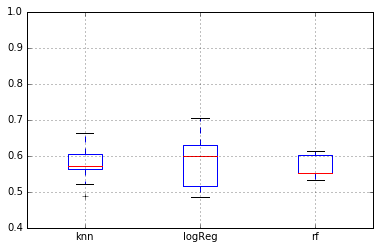

In [374]:
dfDesc.boxplot(by="cls",column=["cv_f1_mean"])
plt.ylim(0.4,1.0)
plt.suptitle("")
plt.xlabel("")
plt.title("")

#### c) Top descriptive classifiers by algorithm type

In [375]:
#Pick one randomly (from the group with same f1)
idx = dfDesc.groupby(['cls'])['cv_f1_mean'].transform(max) == dfDesc['cv_f1_mean']

dfDescIdx = dfDesc[idx]
dfDescIdx = dfDescIdx.groupby("cls").first()
print dfDescIdx.exp.values
dfDescIdx[["fs","sm","metric","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']]

[69 44 59]


,fs,sm,metric,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
cls,,,,,,,,,,,
knn,rfe_rf_fs,none,f1_weighted,"[21, uniform, 5, 0.1]",0.86,0.66+/-0.2,0.7+/-0.21,0.68+/-0.19,0.60,0.62,0.66
logReg,none,none,f1_weighted,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.76,0.77,0.85
rf,none,after,f1_weighted,"[gini, None, None, 150, 5]",1.00,0.61+/-0.18,0.66+/-0.2,0.63+/-0.18,0.84,0.85,0.88


In [376]:
st, p = stats.f_oneway(*[cvs[cvs[:,0] == i,1] for i in dfDescIdx.exp.values])
print "stat:",st, "p-value:", p
print "Means:",[np.mean(cvs[cvs[:,0] == i,1]) for i in dfDescIdx.exp.values]
print "std:",[np.std(cvs[cvs[:,0] == i,1]) for i in dfDescIdx.exp.values]

if p < 0.05:
    #Find pair wise significance tests

    mc = MultiComparison(cvs[:,1], cvs[:,0])
    result = mc.tukeyhsd()

    print(result)
    print(mc.groupsunique) 

stat: nan p-value: nan
Means: [nan, nan, nan]
std: [nan, nan, nan]


#### Plot performances best classifier algorithms

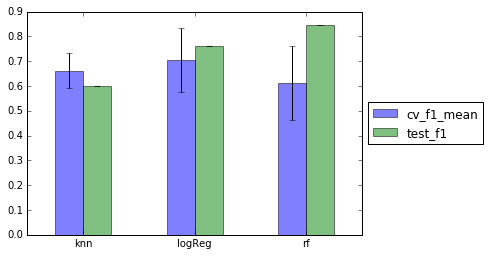

In [377]:
dfDescIdx[["cv_f1_mean","test_f1"]].plot(kind="bar", yerr=[[0.07,0.13,0.15],[0.0,0.0,0.0]], rot=0,alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("")
plt.title("")

#### d) Show all methods with top performances

In [378]:
idx = dfDesc.groupby(['cls'])['cv_f1_mean'].transform(max) == dfDesc['cv_f1_mean']
idx2 = dfDesc[idx].groupby(['cv_f1_mean'])['num_nones'].transform(max) == dfDesc[idx]['num_nones']

dfDesc[idx][idx2][["num_nones","fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']]

,num_nones,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
44,2,none,none,f1_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.76,0.77,0.85
45,2,none,none,precision_weighted,logReg,"[None, 30, l2]",1.00,0.7+/-0.16,0.75+/-0.17,0.71+/-0.16,0.76,0.77,0.85
69,1,rfe_rf_fs,none,f1_weighted,knn,"[21, uniform, 5, 0.1]",0.86,0.66+/-0.2,0.7+/-0.21,0.68+/-0.19,0.60,0.62,0.66
59,1,none,after,f1_weighted,rf,"[gini, None, None, 150, 5]",1.00,0.61+/-0.18,0.66+/-0.2,0.63+/-0.18,0.84,0.85,0.88
51,1,none,after,precision_weighted,rf,"[gini, None, None, 150, 5]",1.00,0.61+/-0.18,0.66+/-0.2,0.63+/-0.18,0.84,0.85,0.88


### 2.3. Pipelines of Non-descriptive Classifier(SVM, ANN)

#### a) Table top-10 classifiers

In [379]:
dfDesc = df[df["cls"].isin(["svmRBF","nn"])]\
        .sort_values("cv_f1_mean", ascending=False)
   
dfDesc[["fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']].iloc[:thr,:]    

,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
50,none,none,f1_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
43,none,none,precision_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
48,none,none,f1_weighted,nn,"[(30, 30), 0.01]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
53,none,after,precision_weighted,svmRBF,"[0.001, None, 3, 50]",1.00,0.7+/-0.16,0.75+/-0.19,0.71+/-0.15,0.76,0.77,0.85
52,none,after,f1_weighted,svmRBF,"[0.001, None, 3, 50]",1.00,0.7+/-0.16,0.75+/-0.19,0.71+/-0.15,0.76,0.77,0.85
58,none,after,f1_weighted,nn,"[(50, 50), 4, 0.01]",1.00,0.7+/-0.14,0.77+/-0.15,0.71+/-0.13,0.76,0.77,0.85
49,none,none,precision_weighted,nn,"[(150,), 0.01]",1.00,0.69+/-0.18,0.76+/-0.2,0.71+/-0.17,0.76,0.77,0.85
12,combine_fs,after,f1_weighted,svmRBF,"[0.001, None, 3, 40, 15]",0.93,0.68+/-0.19,0.7+/-0.2,0.69+/-0.18,0.57,0.62,0.79
41,none,after,precision_weighted,nn,"[(70, 70, 70), 4, 0.01]",1.00,0.67+/-0.18,0.71+/-0.22,0.7+/-0.15,0.76,0.77,0.85
13,combine_fs,after,precision_weighted,svmRBF,"[0.01, None, 3, 20, 1]",0.97,0.66+/-0.15,0.71+/-0.18,0.69+/-0.13,0.76,0.77,0.85


#### b) Plot all pipeline performances grouped by classifier algorithm

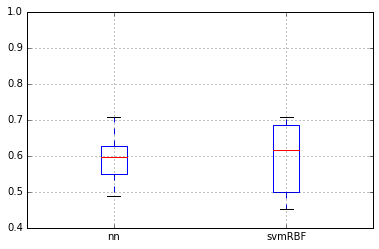

In [380]:
dfDesc.boxplot(by="cls",column=["cv_f1_mean"])
#sns.swarmplot(x="cls", data=dfDesc.groupby("cls")["cv_f1_mean"].groups, color=".25")
plt.ylim(0.4,1.0)
plt.suptitle("")
plt.xlabel("")
plt.title("")

#### c) Top descriptive classifiers by algorithm type

In [381]:
#Pick one randomly (from the group with same f1)
idx = dfDesc.groupby(['cls'])['cv_f1_mean'].transform(max) == dfDesc['cv_f1_mean']
dfDescIdx = dfDesc[idx]
dfDescIdx = dfDescIdx.groupby("cls").first()
dfDescIdx[["fs","sm","metric","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']]

,fs,sm,metric,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
cls,,,,,,,,,,,
nn,none,none,f1_weighted,"[(30, 30), 0.01]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
svmRBF,none,none,f1_weighted,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85


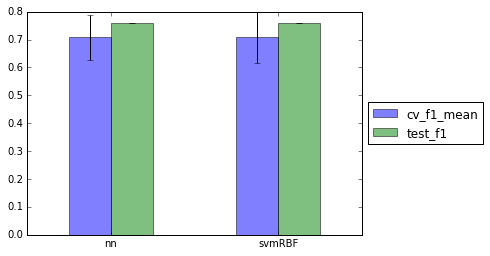

In [382]:
#Plot performances best classifier algorithms
dfDescIdx[["cv_f1_mean","test_f1"]].plot(kind="bar", yerr=[[0.08,0.09],[0.0,0.0]], rot=0,alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("")

#### d) Show all methods with top performances

In [383]:
idx = dfDesc.groupby(['cls'])['cv_f1_mean'].transform(max) == dfDesc['cv_f1_mean']

dfDesc[idx][["fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']]

,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
50,none,none,f1_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
43,none,none,precision_weighted,svmRBF,"[0.001, None, 50]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85
48,none,none,f1_weighted,nn,"[(30, 30), 0.01]",1.00,0.71+/-0.18,0.76+/-0.2,0.72+/-0.17,0.76,0.77,0.85


### 2.4. To CSV

In [384]:
df.to_csv(os.path.join('resources','results',folder,'ds-{}.csv'.format(ds)))

In [385]:
print "Dataset ", ds
print "Total time:", df.time.sum()/3600, "hours"

Dataset  2
Total time: 5.77475739313 hours


In [173]:
print df.fs.unique()
print df.cls.unique()
print df.sm.unique()
print df.metric.unique()

['none' 'rfe_rf_fs' 'combine_fs' 'lasso_fs']
['svmRBF' 'nn' 'logReg' 'rf' 'knn']
['after' 'none']
['f1_weighted' 'precision_weighted']
